https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb

In [2]:
import keras
import nltk
import pandas as pd
import re
import codecs

In [6]:
input_file = codecs.open("../dataset/socialmedia_relevant_cols.csv", "r",encoding='utf-8', errors='replace')
output_file = open("../dataset/socialmedia_relevant_cols_clean.csv", "w",encoding='utf-8')

def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)
sanitize_characters(input_file, output_file)

In [7]:

questions = pd.read_csv("../dataset/socialmedia_relevant_cols_clean.csv")
questions.columns=['text', 'choose_one', 'class_label']
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [8]:
questions.tail()

,text,choose_one,class_label
10808,300K exotic car wrecked in train accident \r\r...,Relevant,1
10809,The twins pitcher's ego is now WRECKED,Not Relevant,0
10810,@Tunes_WGG lol. U got wrecked,Not Relevant,0
10811,you wrecked my whole world,Not Relevant,0
10812,I wrecked my stomach help,Not Relevant,0


In [9]:
questions.describe()

,class_label
count,10813.000000
mean,0.431610
std,0.498302
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [10]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df
questions = standardize_text(questions,"text")
questions.to_csv('../dataset/clean_data.csv')
questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [14]:
clean_questions = pd.read_csv("../dataset/clean_data.csv")
clean_questions.tail()

,Unnamed: 0,text,choose_one,class_label
10808,10808,300k exotic car wrecked in train accident \r\n,Relevant,1
10809,10809,the twins pitcher's ego is now wrecked,Not Relevant,0
10810,10810,lol u got wrecked,Not Relevant,0
10811,10811,you wrecked my whole world,Not Relevant,0
10812,10812,i wrecked my stomach help,Not Relevant,0


In [15]:
clean_questions.groupby('class_label').count()

,Unnamed: 0,text,choose_one
class_label,,,
0,6162,6162,6162
1,4635,4635,4635
2,16,16,16


In [16]:
from nltk.tokenize import RegexpTokenizer

In [17]:
tokenizer = RegexpTokenizer(r'\w+')
clean_questions['tokens'] = clean_questions['text'].apply(tokenizer.tokenize)
clean_questions.head()

,Unnamed: 0,text,choose_one,class_label,tokens
0,0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


In [18]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [19]:
all_words = [word for tokens in clean_questions['tokens'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions['tokens']]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" %(len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

153895 words total, with a vocabulary size of 18065
Max sentence length is 34


In [20]:
import matplotlib.pyplot as plt

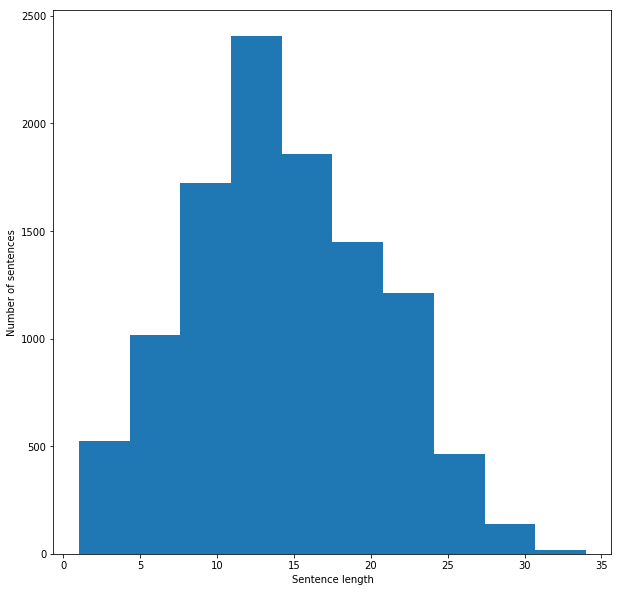

In [21]:
fig = plt.figure(figsize=(10,10))
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()